In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Temperature differences
df = pd.read_csv('./netatmo_stations/diff.csv', delimiter=',')
df.head()

,station,temp_diff,lon,lat
0,70:ee:50:01:60:78,0.454411,-0.888513,41.676094
1,70:ee:50:01:cf:12,1.700149,-0.938232,41.625653
2,70:ee:50:04:ac:ea,0.928233,-1.031000,41.725300
3,70:ee:50:04:b4:36,0.588562,-0.892489,41.677088
4,70:ee:50:04:d3:de,1.690104,-0.864463,41.663082


In [3]:
import pyproj

# Define the CRS for the original (longitude, latitude) and target (projected coordinates)
wgs84 = pyproj.CRS("EPSG:4326")  # WGS84 (longitude, latitude)
utm = pyproj.CRS("EPSG:25830")  # UTM projection (ETRS89 / UTM zone 30N)

# Create a transformer to convert between the two coordinate systems
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

In [4]:
# Apply transformation to each row and modify the DataFrame
df['x'], df['y'] = zip(*df.apply(lambda row: transformer.transform(row['lon'], row['lat']), axis=1))
df.head()

,station,temp_diff,lon,lat,x,y
0,70:ee:50:01:60:78,0.454411,-0.888513,41.676094,675757.042891,4.615968e+06
1,70:ee:50:01:cf:12,1.700149,-0.938232,41.625653,671752.285110,4.610267e+06
2,70:ee:50:04:ac:ea,0.928233,-1.031000,41.725300,663771.088315,4.621151e+06
3,70:ee:50:04:b4:36,0.588562,-0.892489,41.677088,675423.336049,4.616070e+06
4,70:ee:50:04:d3:de,1.690104,-0.864463,41.663082,677794.821735,4.614573e+06


In [5]:
# Go to raster directory
raster_dir = '../data/rasters'
os.chdir(raster_dir)

In [6]:
# List all .tif files
list = glob.glob('*.tif')
list

['Zaragoza_ETRS89_NDVI_scaled_old.tif',
 'interpolation_SVF+IMD+NDVI_scaled.tif',
 'Zaragoza_ETRS89_NDVI_scaled.tif',
 'Zaragoza_ETRS89_MDS05.tif',
 'Zaragoza_ETRS89_SWIR2_normalized_scaled_old.tif',
 'Zaragoza_ETRS89_SWIR2_normalized_scaled.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled.tif',
 'Zaragoza_ETRS89_Terrain_Ruggedness_Index.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled_old.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled_old.tif',
 'Zaragoza_ETRS89_Sky_View_Factor.tif',
 'predictors_skf_imd_ndvi.tif',
 'Zaragoza_ETRS89_SWIR2.tif',
 'Zaragoza_ETRS89_SWIR2_normalized.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled.tif',
 'Zaragoza_ETRS89_Total_Insolation.tif',
 'Zaragoza_ETRS89_Visible_Sky.tif',
 'interpolation_SVF+IMD+NDVI.tif',
 'Zaragoza_ETRS89_NDVI.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_Simplified.tif',
 'Zaragoza_ETRS89_Imperviousness_Density.tif']

EPSG:25830


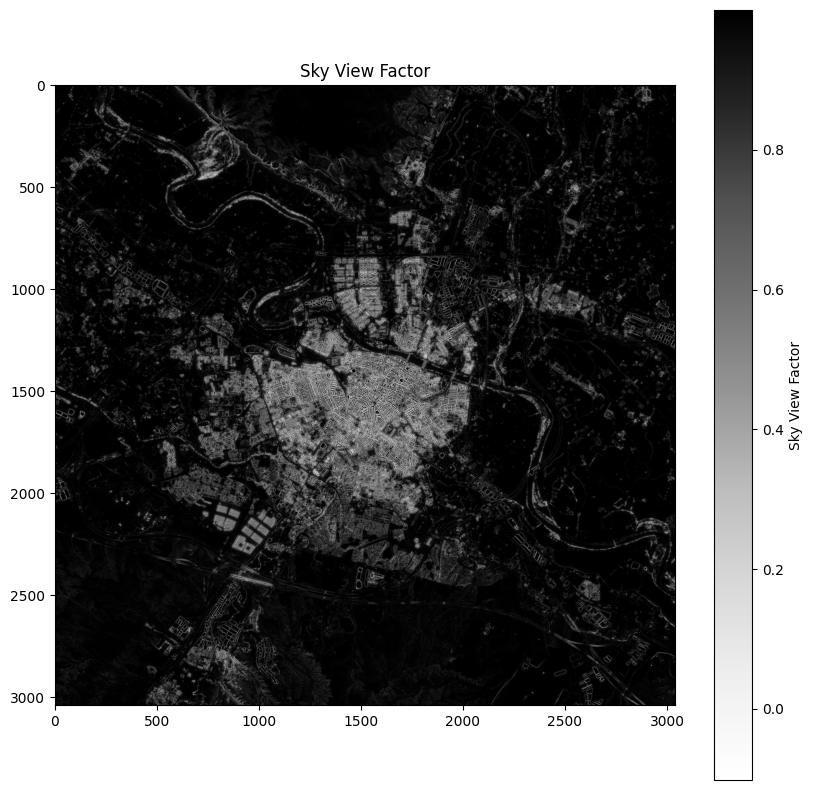

In [7]:
svf_raster_path = 'Zaragoza_ETRS89_Sky_View_Factor.tif'
with rasterio.open(svf_raster_path) as src:
    print(src.crs)
    svf = src.read(1)

    # Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])

    lons, lats = coords[:, 0], coords[:, 1]

    # Get SVF values
    svfs = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            svf_value = svf[row, col]
            svfs.append(svf_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            svfs.append(np.nan)  # Append NaN for out-of-bounds
    df['svf'] = svfs
    
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

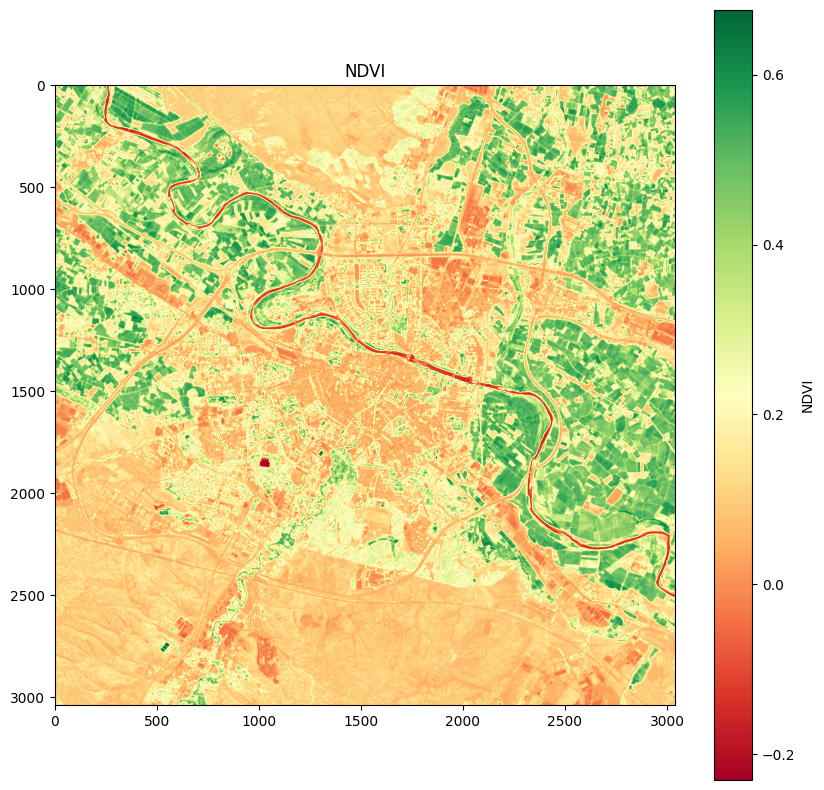

In [8]:
ndvi_raster_path = 'Zaragoza_ETRS89_NDVI.tif'
with rasterio.open(ndvi_raster_path) as src:
    #ndvi = src.read(1)
    ndvi = src.read(
        out_shape=(
            src.count,
            int(3039),
            int(3039)
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDVI values
    ndvis = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
    
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            ndvi_value = ndvi[row, col]
            ndvis.append(ndvi_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            ndvis.append(np.nan)  # Append NaN for out-of-bounds
    df['ndvi'] = ndvis
    
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title(f'NDVI')
plt.show()

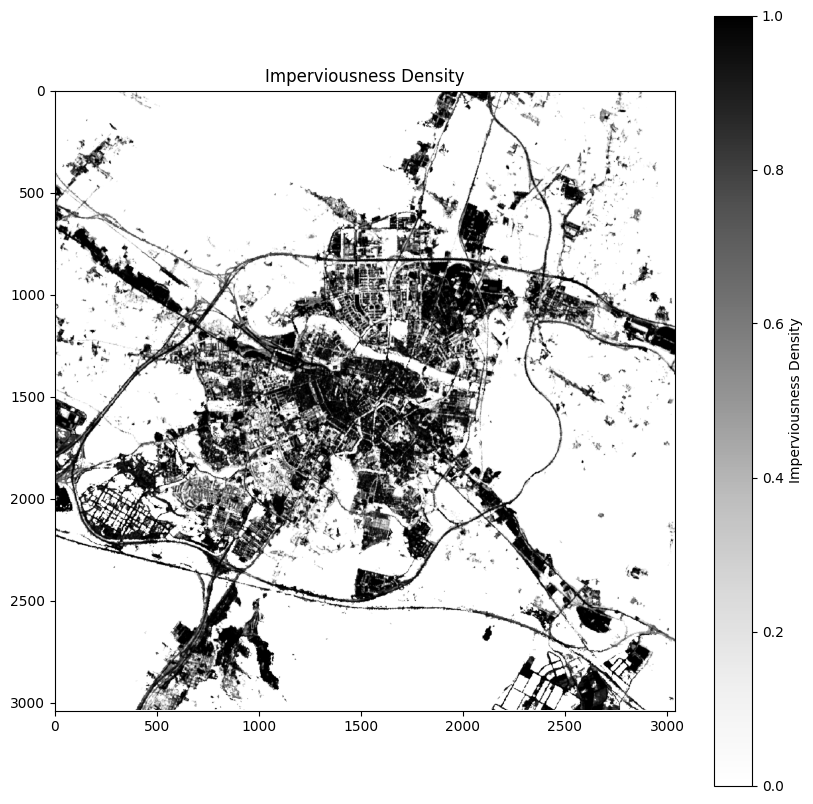

In [9]:
imd_raster_path = 'Zaragoza_ETRS89_Imperviousness_Density_normalized.tif'
with rasterio.open(imd_raster_path) as src:
    #imd = src.read(1)
    imd = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get IMD values
    imds = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            imd_value = imd[row, col]
            imds.append(imd_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            imds.append(np.nan)  # Append NaN for out-of-bounds
    df['imd'] = imds
    
plt.figure(figsize=(10, 10))
plt.imshow(imd, cmap='Grays')
plt.colorbar(label='Imperviousness Density')
plt.title(f'Imperviousness Density')
plt.show()

In [10]:
df.head()

,station,temp_diff,lon,lat,x,y,svf,ndvi,imd
0,70:ee:50:01:60:78,0.454411,-0.888513,41.676094,675757.042891,4.615968e+06,0.295339,0.332429,0.000000
1,70:ee:50:01:cf:12,1.700149,-0.938232,41.625653,671752.285110,4.610267e+06,0.786471,0.425414,0.013551
2,70:ee:50:04:ac:ea,0.928233,-1.031000,41.725300,663771.088315,4.621151e+06,NaN,NaN,NaN
3,70:ee:50:04:b4:36,0.588562,-0.892489,41.677088,675423.336049,4.616070e+06,0.564394,0.428031,0.000000
4,70:ee:50:04:d3:de,1.690104,-0.864463,41.663082,677794.821735,4.614573e+06,0.327050,0.288496,0.000000


In [11]:
df = df.drop(columns=['x', 'y'])
df.head()

,station,temp_diff,lon,lat,svf,ndvi,imd
0,70:ee:50:01:60:78,0.454411,-0.888513,41.676094,0.295339,0.332429,0.000000
1,70:ee:50:01:cf:12,1.700149,-0.938232,41.625653,0.786471,0.425414,0.013551
2,70:ee:50:04:ac:ea,0.928233,-1.031000,41.725300,NaN,NaN,NaN
3,70:ee:50:04:b4:36,0.588562,-0.892489,41.677088,0.564394,0.428031,0.000000
4,70:ee:50:04:d3:de,1.690104,-0.864463,41.663082,0.327050,0.288496,0.000000


In [12]:
# Drop NaNs
df = df.dropna()
df.head()

,station,temp_diff,lon,lat,svf,ndvi,imd
0,70:ee:50:01:60:78,0.454411,-0.888513,41.676094,0.295339,0.332429,0.000000
1,70:ee:50:01:cf:12,1.700149,-0.938232,41.625653,0.786471,0.425414,0.013551
3,70:ee:50:04:b4:36,0.588562,-0.892489,41.677088,0.564394,0.428031,0.000000
4,70:ee:50:04:d3:de,1.690104,-0.864463,41.663082,0.327050,0.288496,0.000000
5,70:ee:50:05:61:46,1.447072,-0.934771,41.630554,0.837236,0.048184,0.445574


In [13]:
df.to_csv('../../zaragoza/data_netatmo.csv', index=False)